In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Taxes,28.657125,2.865713,10
Dataverse Queries,192.771116,96.385558,2
"CDK Global Ransomeware, June 2024",214.761004,35.793501,6
Powershell,283.410043,13.495716,21
Finance Junk,306.396292,38.299536,8
Kali Linux,500.110123,100.022025,5
Azure AI Foundry,579.265426,38.617695,15
Dataverse Plugins,752.043199,107.434743,7
AKS,774.586115,96.823264,8
pandas,801.307010,100.163376,8


# Histogram

27453.69


<Axes: >

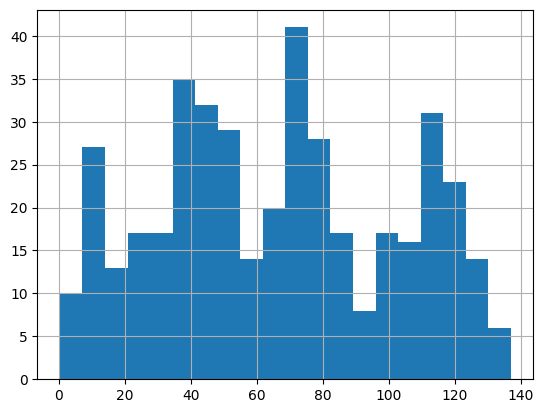

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
remake_card_document(existing_cards)

Cards found: 415


# Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [12]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [13]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Mean

In [15]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
existing_cards.head(10)

remake_card_document(existing_cards=existing_cards)


Cards found: 415


In [16]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
71,MS Identity Platform,OpenID Connect versus SAML: The platform uses ...,44b237b8e558e4cc0f48efc03675f0a0,-126.516092,-117.304752,126.516092,1290.352268,0.600128,0,0
72,MS Identity Platform,URIs for certain apps:\n○ Apps that use embedd...,af75a6029c7b258a77de1b930aed60fc,-123.563139,-117.304752,126.516092,1290.352268,0.600128,1,0
73,MS Identity Platform,Authentication scenarios involve two activitie...,c4b8222ecdb2c8c755df523bddf91330,-122.135090,-117.304752,126.516092,1290.352268,0.600128,2,0
109,Diffusers Library,Unconditional Image Generation: Generate an im...,396c6b73832a9d9ad8b8c0e6d9ef13b6,-136.540628,-116.732758,136.540628,1867.724130,0.390396,0,0
111,Diffusers Library,There are three main components of the library...,d9b2db7c5f3a503d7a94e5260d69dbf3,-125.008934,-116.732758,136.540628,1867.724130,0.390396,1,0
110,Diffusers Library,Running pip install within a Jupyter notebook ...,24e8a5ffabee8d40d521a47a958f70f2,-123.469400,-116.732758,136.540628,1867.724130,0.390396,2,0
13,Conditional Access,"During sign-in, policies in report-only mode a...",5cb29b92ba9ae794ee0f8af30d47c348,-128.935376,-115.078205,128.935376,805.547432,0.860292,0,0
14,Conditional Access,Token Renewal: Refresh tokens are used to obta...,5c3e85df02d00ab354fb612c17f35134,-116.372683,-115.078205,128.935376,805.547432,0.860292,1,0
15,Conditional Access,Report-only: Not applied\t\nNot all configured...,a5346313cfa4af9df8926096c2ddb977,-115.727246,-115.078205,128.935376,805.547432,0.860292,2,0
20,Dataverse Plugins,The Plugin Execution Pipeline defines the sequ...,00f25da99235c2fc081ffb70d3a059bf,-129.544273,-107.434743,129.544273,752.043199,0.853535,0,0


In [17]:
existing_cards.head(10)['age'].sum()

-1247.812859588931